# Bin Packing Lab

- Authors:
  - Luigi Quattrociocchi (quattrl@mcmaster.ca)
  - Dennis Fong (fongd1@mcmaster.ca)
- Group ID on Avenue: 42
- Gitlab URL: https://gitlab.cas.mcmaster.ca/quattrl/l2-bin-packing

## Task 1

### Explanation of SOLID principles

The given code follows many design practices and implements many classic design patterns. This allows it to fulfil a couple of the SOLID principles.

**S: Single Responsibility**  
Each class has a single responsibility. For instance, the `DatasetReader` class is only responsible for transforming data from the disk into a format usable by other classes. Likewise, each concrete bin packing problem implementation has one responsibility: solving the bin packing problem.

**O: Open-closed**  
The existence of the `Online` and `Offline` abstract classes allow for extentibility in the addition of new algorithms, without requiring modifications of any existing classes. The same reasoning applies for the `DatasetReader` class.

**L: Liskov substitution**  
This is obviously satified with the `Online` and `Offline` base classes and its derived classes; the online and offline bin packing algorithms `NextFit_On`, `NextFit_Off`, and `BenMaier`, can be used as if they were their parent classes `Online` and `Offline`.

**I: Interface Segregation**  
This property is also obviously maintained. Both `BinPacker` subclasses and `DatasetReader` only provide one abstract method each, which every subclass implements. The `BinPacker` interface itself has no methods, as there is currently no shared interface between the online and offline algorithms (the process functions take different sets of parameters).

**D: Dependency Inversion**  
Similarly to the Liskov substitution principle, the abstract classes `Online` and `Offline` can be depended upon rather than their concrete subclasses. This is demonstrated in the Jupyter Notebook, in which online and offline strategies are created and used.

### Explanation of dataset dimensions
There are three important dimensions which we consider in the dataset.
- N: Number of items
- C: Bin capacity
- W: Weight (size) of each item

**Number of items**  
This number represents the total number of items we want to put into bins. This quantity is important because the time and space required to solve the bin packing problem with N items is proportional to N.

**Bin capacity**  
This number represents the capacity (maximum weight) of each bin. This quantity is important because the number of bins required in the optimal solution will be inversely proportional to the bin capacity. Some algorithms can take advantage of small capacities to come closer to an optimal solution.

**Weight of each item**  
This number represents the weight (or size) of each item. This quantity is important because the weight of each bin (relative to the bin capacity) can dictate the number of bins required in the optimal solution. Additionally, the weight of the bins can impact the optimality of certain algorithms.


## Task 2

Each column represents a single test case, read columnwise to compare algorithms on the same input.


Test Case A                                       Test Case B                                       Test Case C                                       

Case: "N4C1W1_A.BPP_NextFit_Online":              Case: "N1C3W1_A.BPP_NextFit_Online":              Case: "N1C1W4_A.BPP_NextFit_Online":              
KPI 1: Num bins     = 315                         KPI 1: Num bins     = 19                          KPI 1: Num bins     = 42                          
KPI 2: Wastefulness = 6387                        KPI 2: Wastefulness = 469                         KPI 2: Wastefulness = 1003                        
Execution time: 0.105ms                           Execution time: 0.010ms                           Execution time: 0.013ms                           


Case: "N4C1W1_A.BPP_FirstFit_Online":             Case: "N1C3W1_A.BPP_FirstFit_Online":             Case: "N1C1W4_A.BPP_FirstFit_Online":   

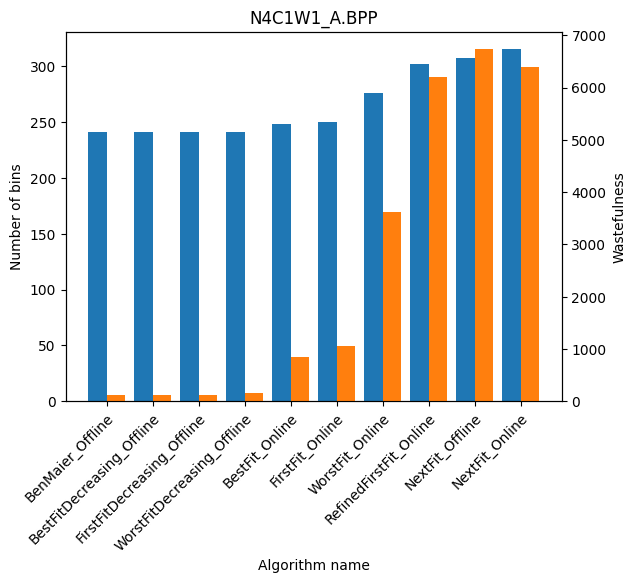

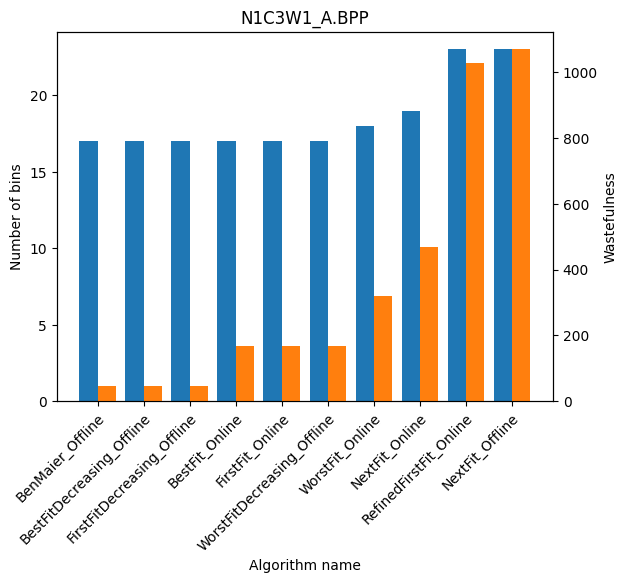

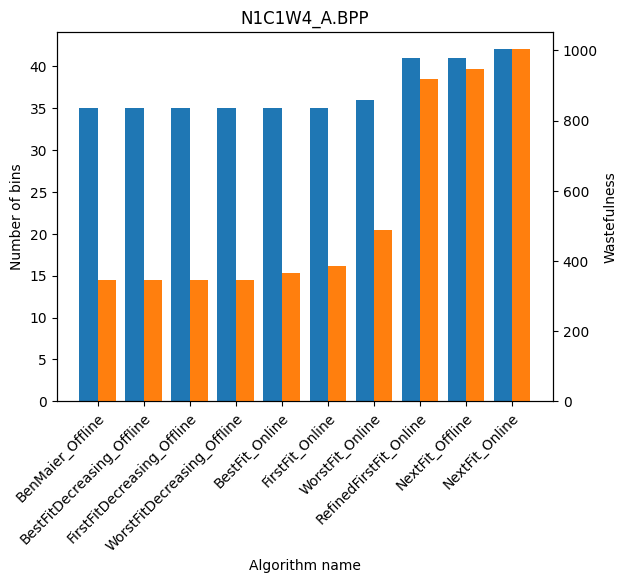

In [22]:
# Run and visualize benchmark
BENCHMARK_FILENAME = "outputs/pyperf_measurements_capacity.json"

# Run the benchmark only if a bencmkark results file outputted by pyperf does not exist
import os
if not os.path.exists(BENCHMARK_FILENAME):
    print("Running benchmark. This may take some time, go get a coffee or something...")
    !pipenv run python benchmark_capacity.py -o $BENCHMARK_FILENAME


import matplotlib.pyplot as plt
from pyperf import BenchmarkSuite
from benchmark_capacity import get_case_name, get_case_data, get_algo_name, all_cases, all_offline, all_online, make_bench_name
num_cases = len(all_cases())
benchmarks = BenchmarkSuite.load(BENCHMARK_FILENAME).get_benchmarks()
execution_times = [bench.median() for bench in benchmarks]
time_idx = 0

results = [[] for _ in range(num_cases)]
padding = 50
print("Each column represents a single test case, read columnwise to compare algorithms on the same input.\n\n")
print("".join(f"Test Case {chr(i + 65)}".ljust(padding) for i in range(num_cases)))
print(("=" * (padding * num_cases)) + "\n")
for algorithm in all_online() + all_offline():
    lines = [""]*4
    for i, case in enumerate(all_cases()):
        name = get_case_name(case)
        data = get_case_data(case)
        bench_name = make_bench_name(name, algorithm)
        result = algorithm(data)
        results[i].append((result, get_algo_name(algorithm)))
        lines[0] += f'Case: "{bench_name}":'.ljust(padding)
        lines[1] += f'KPI 1: Num bins     = {result.num_bins}'.ljust(padding)
        lines[2] += f'KPI 2: Wastefulness = {result.wastefulness}'.ljust(padding)
        lines[3] += f'Execution time: {execution_times[time_idx] * 1000:.3f}ms'.ljust(padding)
        time_idx += 1
    print("\n".join(lines))
    print("\n" + ("=" * (padding * num_cases)) + "\n")

for i, row in enumerate(results):
    row.sort()
    _, ax1 = plt.subplots(1, 1)
    answers, names = zip(*row)
    n = len(answers)
    bar_x = [x for x in range(n)]
    bar1_x = [x-0.2 for x in bar_x]
    bar2_x = [x+0.2 for x in bar_x]
    data1 = [a.num_bins for a in answers]
    data2 = [a.wastefulness for a in answers]
    ax1.bar(bar1_x, data1, width=0.4)
    _ = plt.ylabel("Number of bins")
    _ = plt.xlabel("Algorithm name")
    ax2 = ax1.twinx()
    _ = plt.ylabel("Wastefulness")
    ax2.bar(bar2_x, data2, width=0.4, color='tab:orange')
    plt.xticks(bar_x, names)
    ax1.set_xticks(ax1.get_xticks(), names, rotation=45, ha='right', rotation_mode='anchor')
    ax1.set_title(get_case_name(all_cases()[i]))
    

#### Benchmarking
For our benchmarking, we selected three test cases from the `Binpp` dataset to stress our algorithms. We chose our cases to isolate each dimension of the bin packing problem (N, C, and W). For example, one test case uses an input with N4 (representing 500 items to be placed into bins), whilst the other two test cases had N1 (representing only 50 items to be placed into bins). We isolated capacity and weight the same way as well.

In order to analyse the different algorithms, we define key metrics that we use to measure the effectiveness of each algorithm. The number of bins used is the primary metric. The goal of these algorithms is the use the least number of bins, thus the number of bins used will be the the most important measure (to minimize). Another metric is the "wastefulness" of the algorithm. This measures how close each bin in a solution is to being either completely full, or completely empty. We wish to minimize this, as we want to avoid having many bins that are half-full. Having half-full bins is wasteful because it is not possible to fit items with large weights into these bins. This metric will be used to compare algorithms that output the same number of bins, and "break ties" between seemingly equal solutions.

#### Analysis of algorithms
After creating and analyizng the graphs, we observed that the naive `NextFit` (Online and Offline) algorithms perform the worst by far. This aligns with our expectations, as that algorithm is the most "short-sighted". Also as we'd expect, the online version performs much worse than the offline version. The next worst algorithm is `WorstFit`, but is far better than `NextFit`. All the other algorihtms perform similarly to each other, with the notable exception that the offline algorithms almost always do better than their online counterparts. This also makes sense, as the impact of pre-sorting does cause for more efficient packings. All the non-naive offline algorithms tie with the  baseline algorithm by `BenMaier`, although the "wastefulness" scores vary slightly in favour of the baseline. Looking at the publicly avaliable source code of the baseline algorithm, this makes sense, as they basically implemented a variation of `BestFitDecreasing`. One slightly amusing result was that the baseline algorithm was by far the slowest, taking approximately 10ms on the large test case. In comparison, our slow $N^2$ implementations run in about 4ms and 5ms for the same input.

## Task 3

In [2]:
from macpacking.utils import read_csv_contents
from macpacking.reader import BinppReader, JBurkardtReader

from os import listdir
from os.path import join, isdir, basename
datasets = [
    join('.', '_datasets', 'binpp'),
    join('.', '_datasets', 'binpp-hard'),
    join('.', '_datasets', 'jburkardt'),
]

case_data = {}
oracle = {}
for dataset in datasets:
    oracle_path = join(dataset, "oracle.csv")
    oracle_contents = read_csv_contents(oracle_path)
    for entry in oracle_contents:
        oracle[entry['Problem']] = entry['Optimal']


binpp_dir = datasets[0]
for folder in listdir(binpp_dir):
    folder = join(binpp_dir, folder)
    if not isdir(folder): continue
    for test_case in listdir(folder):
        test_case = join(folder, test_case)
        name = basename(test_case)[:-8]
        reader = BinppReader(test_case)
        case_data[name] = reader.offline()

binpp_hard_dir = datasets[1]
for test_case in listdir(binpp_hard_dir):
    if not test_case.startswith('HARD'):
        continue
    test_case = join(binpp_hard_dir, test_case)
    name = basename(test_case)[:-8]
    reader = BinppReader(test_case)
    case_data[name] = reader.offline()
    
import re
jburkardt_dir = datasets[2]
for test_case in listdir(jburkardt_dir):
    match = re.findall("p(\d+)_c.txt", test_case)
    if len(match) == 0: continue
    case_num = match[0]
    name = f"p_{case_num}"
    capacity_file = join(jburkardt_dir, f"p{case_num}_c.txt")
    weights_file = join(jburkardt_dir, f"p{case_num}_w.txt")
    reader = JBurkardtReader(capacity_file, weights_file)
    case_data[name] = reader.offline()

from collections import defaultdict
case_results = defaultdict(dict)
algorithms = all_online() + all_offline()
for name, data in case_data.items():
    for algorithm in algorithms:
        result = algorithm(data)
        case_results[name][get_algo_name(algorithm)] = result

In [3]:
from IPython.display import display, HTML
display(HTML("""<b>These results are very long. Click <a href="#skip">here</a> to skip to the next section.</b>"""))

padding = 34
for case_name, results in case_results.items():
    print(f"{case_name}:")
    print(f"    Oracle: ".ljust(padding), oracle[case_name])
    for algo_name, result in results.items():
        print(f"    {algo_name}: ".ljust(padding), result.num_bins, f"({result.num_bins - oracle[case_name]} bins from optimal solution)")


N1C1W1_A:
    Oracle:                        25
    NextFit_Online:                32 (7 bins from optimal solution)
    FirstFit_Online:               26 (1 bins from optimal solution)
    BestFit_Online:                26 (1 bins from optimal solution)
    WorstFit_Online:               28 (3 bins from optimal solution)
    RefinedFirstFit_Online:        30 (5 bins from optimal solution)
    NextFit_Offline:               30 (5 bins from optimal solution)
    FirstFitDecreasing_Offline:    25 (0 bins from optimal solution)
    BestFitDecreasing_Offline:     25 (0 bins from optimal solution)
    WorstFitDecreasing_Offline:    25 (0 bins from optimal solution)
    BenMaier_Offline:              25 (0 bins from optimal solution)
N1C1W1_B:
    Oracle:                        31
    NextFit_Online:                36 (5 bins from optimal solution)
    FirstFit_Online:               31 (0 bins from optimal solution)
    BestFit_Online:                31 (0 bins from optimal solution)
    Wor

<a id="skip"></a>

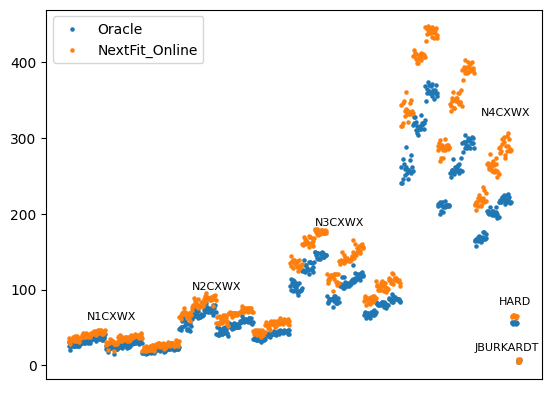

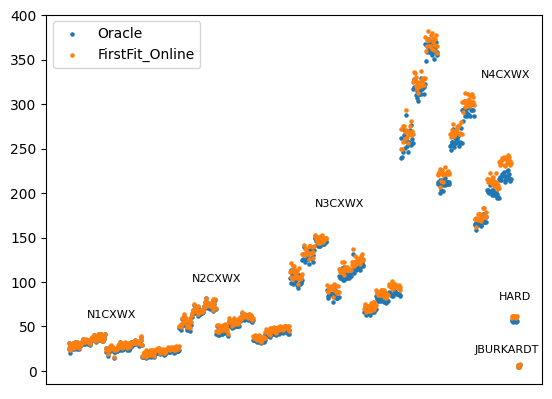

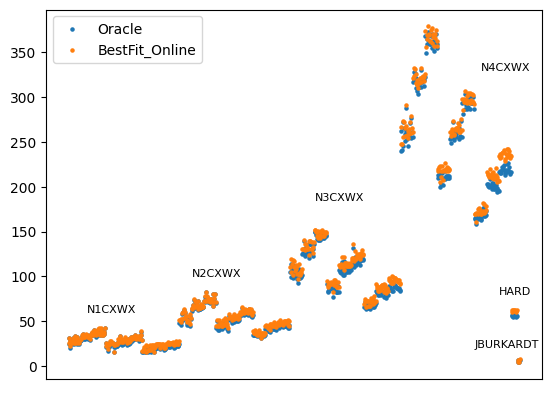

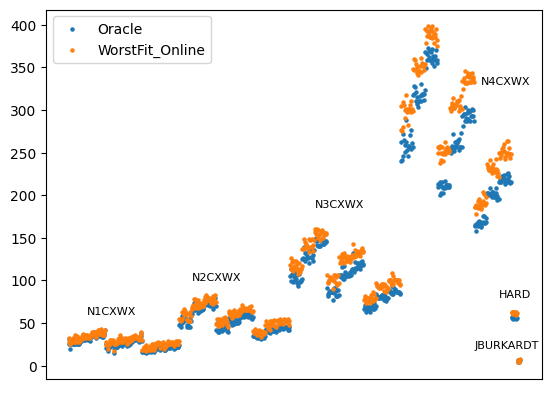

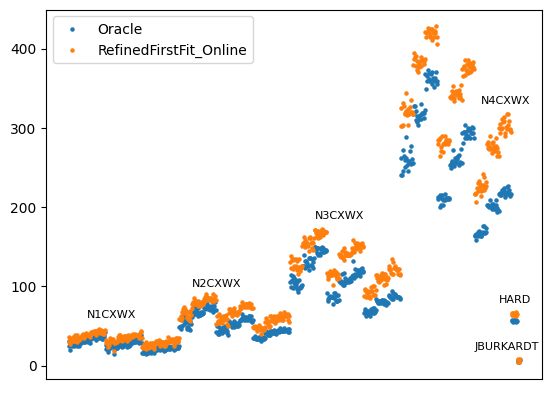

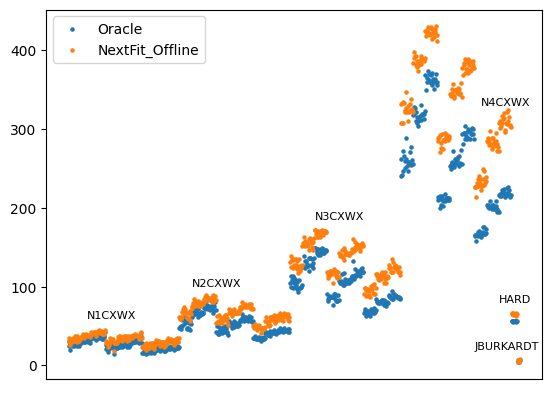

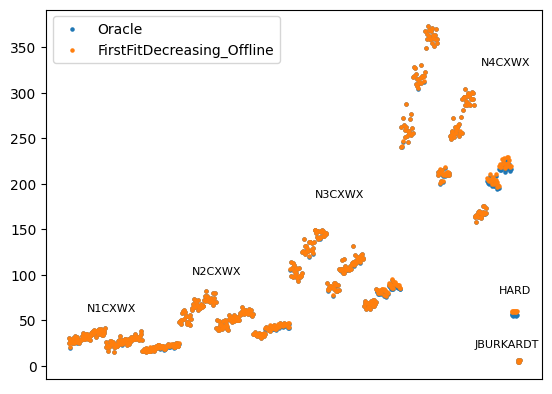

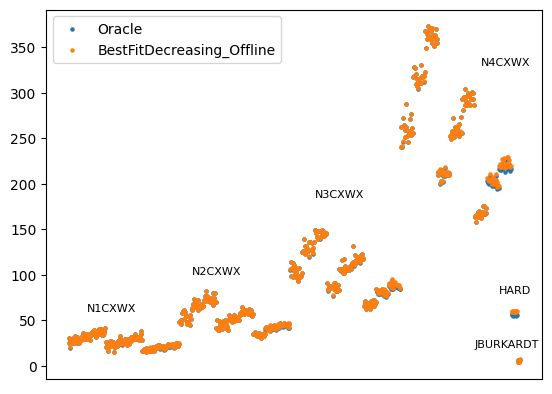

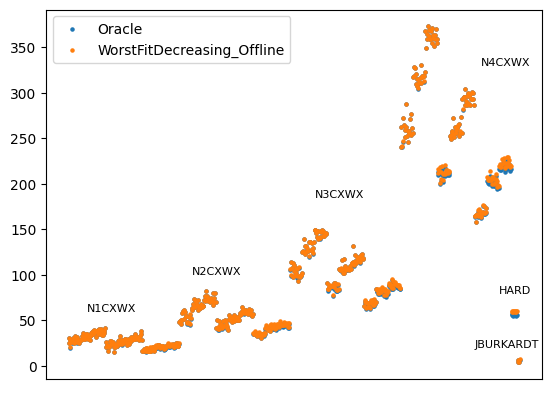

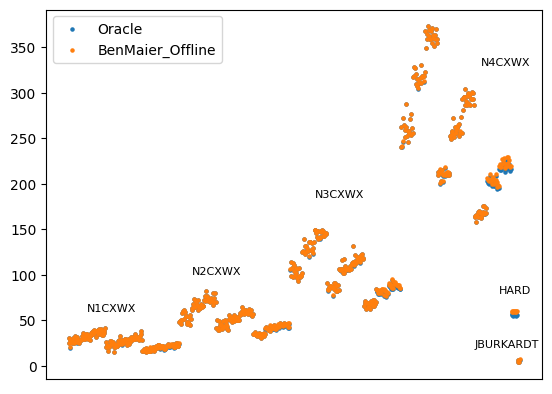

In [4]:
results_per_algo = {}
for algorithm in algorithms:
    name = get_algo_name(algorithm)
    results_per_algo[name] = {k:d[name] for k, d in case_results.items()}

for k, v in results_per_algo.items():
    _, ax = plt.subplots(1, 1)
    plt.xticks([])
    # plt.yticks([])
    aa, bb = list(zip(*oracle.items()))
    ax.scatter(aa, bb, s=5, label="Oracle")
    aa, bb = list(zip(*v.items()))
    # aa, bb = list(zip(*sorted(v.items(), key=lambda t: (t[1], t[0]))))
    ax.scatter(aa, [a.num_bins for a in bb], s=5, label=k)
    ax.legend()
    ax.annotate('N1CXWX', xy=(0,0),xytext=(30,60), fontsize=8)
    ax.annotate('N2CXWX', xy=(0,0),xytext=(200,100), fontsize=8)
    ax.annotate('N3CXWX', xy=(0,0),xytext=(400,185), fontsize=8)
    ax.annotate('N4CXWX', xy=(0,0),xytext=(670,330), fontsize=8)
    ax.annotate('HARD', xy=(0,0),xytext=(700,80), fontsize=8)
    ax.annotate('JBURKARDT', xy=(0,0),xytext=(660,20), fontsize=8)

#### Which cases are problematic
We used a scatter plot for each algorithm to plot it against the optimal solution given in the `oracle.xslx` file. In each plot, the x-axis is each test case and the y-axis is the number of bins. For each plot, the orange points represent the numbers of bins used by the algorithm, and the blue points repesent the optimal solution for the same input (as given by the oracle). We use a scatter plot because it becomes very easy to compare the solutions to the optimal solution; we simply look at the difference in height of the orange clusters and the blue clusters. Since the different test cases are plotted on the x-axis, we can visually recognize clusters of test cases in our datasets. Most of the cases come from the `Binpp` dataset. There are four main clusters (each annotated "N_CXWX") which represent test cases with some number of items (N1(50), N2(100), N3(200), N4(500)) to pack. Each "sub-cluster" (three in each main cluster) shows test cases with a different bin capacity (C1(100), C2(120), C3(150)). After recognizing these clusters, we can easily search for patterns in our results. We can also observe the `BinppHard` and `JBurkardt` datasets as small clusters in the bottom right of each plot. These datasets are not as useful to us since there are less test cases within them.

From the plots, we can see that the `BenMaier` (Offline), `WorstFitDecreasing` (Offline), `BestFitDecreasing` (Offline), and  `FirstFitDecreasing` (Offline) algorithms provide solutions that are nearly optimal, with some test cases as exceptions. However, every other algorithm provides solutions that are far from optimal, even for smaller simple inputs. Again, this makes sense intuitively, as the other algorithms are either naive algorihtms, or Online. The non-optimality of these algorithms is even more pronounced for test cases with larger values of N (N3 and N4 test cases have 200 items and 500 items, respectively). Higher values of N exemplify the poor performance of the naive algorithms, and how far they stray away from the optimal solution. Thus, the most problematic test cases tend to be those with more items to pack. Naturally, this makes sense, as the more items you have, the more possible arrangements of bins exist. Since more arrangements exist, there are more arrangements that are non-optimal. Most of the time, it becomes very difficult for the naive algorithms to compute the ideal way to allocate the items into bins.

## Task 4
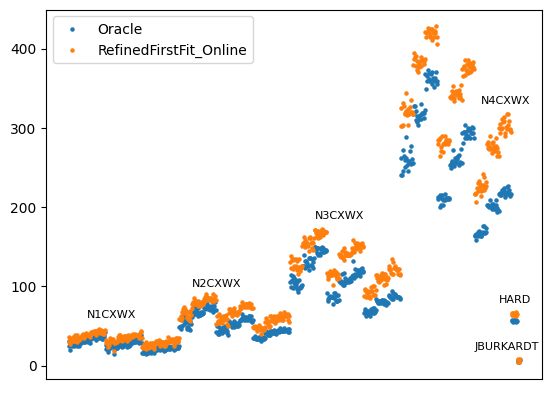</img>



## Task 5

In [5]:
# from macpacking.algorithms.num_bins.baseline import BenMaier
# from macpacking.algorithms.num_bins.offline import Greedy, MultiFit
# from macpacking.reader import BinppReader, JBurkardtReader

# reader = BinppReader('_datasets/binpp/N4C3W4/N4C3W4_A.BPP.txt')
# data = reader.offline()
# a = BenMaier()(data)
# print(a)
# b = Greedy()(data)
# print(b)
# c = MultiFit()(data)
# print(c)

Each column represents a single test case, read columnwise to compare algorithms on the same input.


100 bins                                          200 bins                                          400 bins                                          

Case: "N4C3W4_A.BPP_Greedy_Offline_100":          Case: "N4C3W4_A.BPP_Greedy_Offline_200":          Case: "N4C3W4_A.BPP_Greedy_Offline_400":          
KPI 1: Largest bin = 329                          KPI 1: Largest bin = 186                          KPI 1: Largest bin = 100                          
KPI 2: Difference  = 11                           KPI 2: Difference  = 42                           KPI 2: Difference  = 43                           
Execution time: 4.663ms                           Execution time: 9.121ms                           Execution time: 18.478ms                          


Case: "N4C3W4_A.BPP_MultiFit_Offline_100":        Case: "N4C3W4_A.BPP_MultiFit_Offline_200":        Case: "N4C3W4_A.BPP_MultiFit_Offline_400

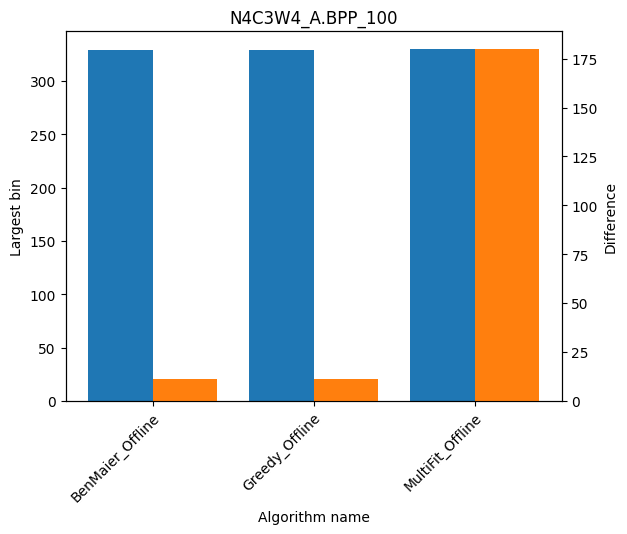

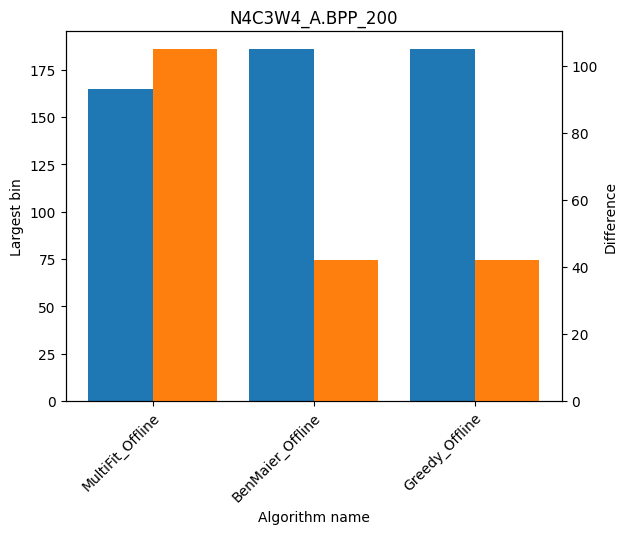

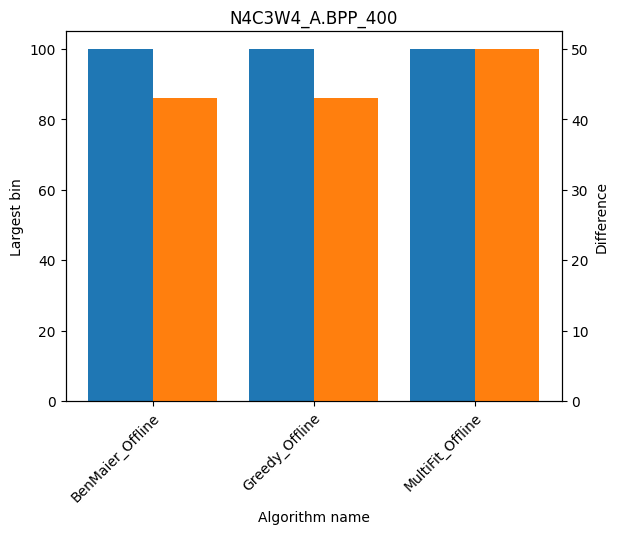

In [30]:
# Run and visualize benchmark
BENCHMARK_FILENAME = "outputs/pyperf_measurements_num_bins.json"

# Run the benchmark only if a bencmkark results file outputted by pyperf does not exist
import os
if not os.path.exists(BENCHMARK_FILENAME):
    print("Running benchmark. This may take some time, go get a coffee or something...")
    !pipenv run python benchmark_num_bins.py -o $BENCHMARK_FILENAME


import matplotlib.pyplot as plt
from pyperf import BenchmarkSuite
from benchmark_num_bins import get_case_name, get_case_data, get_algo_name, all_cases, all_num_bins, all_offline, all_online, make_bench_name
num_cases = len(all_num_bins())
benchmarks = BenchmarkSuite.load(BENCHMARK_FILENAME).get_benchmarks()
execution_times = [bench.median() for bench in benchmarks]
# print(execution_times)
time_idx = 0

results = [[] for _ in range(num_cases)]
padding = 50
print("Each column represents a single test case, read columnwise to compare algorithms on the same input.\n\n")
print("".join(f"{x} bins".ljust(padding) for x in all_num_bins()))
print(("=" * (padding * num_cases)) + "\n")
for algorithm in all_online() + all_offline():
    lines = [""]*4
    for i, num_bins in enumerate(all_num_bins()):
        for case in all_cases():
            name = get_case_name(case)
            data = get_case_data(case)
            bench_name = make_bench_name(name, algorithm) + f"_{num_bins}"
            result = algorithm((num_bins, data[1]))
            results[i].append((result, get_algo_name(algorithm)))
            lines[0] += f'Case: "{bench_name}":'.ljust(padding)
            lines[1] += f'KPI 1: Largest bin = {result.largest}'.ljust(padding)
            lines[2] += f'KPI 2: Difference  = {result.difference}'.ljust(padding)
            lines[3] += f'Execution time: {execution_times[time_idx] * 1000:.3f}ms'.ljust(padding)
            time_idx += 1
    print("\n".join(lines))
    print("\n" + ("=" * (padding * num_cases)) + "\n")

# print(results)
for i, row in enumerate(results):
    row.sort()
    _, ax1 = plt.subplots(1, 1)
    answers, names = zip(*row)
    n = len(answers)
    bar_x = [x for x in range(n)]
    bar1_x = [x-0.2 for x in bar_x]
    bar2_x = [x+0.2 for x in bar_x]
    data1 = [a.largest for a in answers]
    data2 = [a.difference for a in answers]
    ax1.bar(bar1_x, data1, width=0.4)
    _ = plt.ylabel("Largest bin")
    _ = plt.xlabel("Algorithm name")
    ax2 = ax1.twinx()
    _ = plt.ylabel("Difference")
    ax2.bar(bar2_x, data2, width=0.4, color='tab:orange')
    plt.xticks(bar_x, names)
    ax1.set_xticks(ax1.get_xticks(), names, rotation=45, ha='right', rotation_mode='anchor')
    ax1.set_title(get_case_name(all_cases()[0]) + f"_{all_num_bins()[i]}")
    

#### Metrics

During benchmarking, we also computed a few different metrics, relevant to the problem. One is the largest bin weight, and the other is the difference between the largest and smallest bins from each algorithm. When comparing the algorithms, a lower max bin weight shows that the algorithm is able to balance out the weights more evenly, compared to another algorithm. This is because with a lower max, we reduce the maximum load in any bin. Next, the other metric is useful because it quantifies the maximum spread of weights among bins. Different algorithms prioritize this over the other metric, so it is difficult to compare algorithms based on one metric alone. Thus, we use both of these metrics to justify which algorithm performs better.

#### Analysis of algorithms
We ran the three algorithms (`Greedy`, `MultiFit`, and the baseline `BenMaier`) on the same large test case with different numbers of bins (100, 200, and 400). A couple notable observations can be made from the results presented in the plots above. Firstly, the baseline algorithm performs identically to the Greedy algorithm in all of our runs. Once again, we can look at the source code for the baseline algorithm and notice that they also use the same greedy algorithm for selecting bins. Interestingly though, the runtime of the baseline algorithm is much lower (about 3x faster than our implementation) in every case.

The multifit algorithm was also much slower in terms of execution time, but produced very different solutions than the other algorithms. For the cases we tested, multifit was on-par with or better than the baseline algorithm in terms of largest single bin. The other metric (difference between largest and smallest single bins) is not something that MultiFit cares about, thus it was always beaten in this regard.

## Self-reflection questions

As part of the self-reflection dimension of an experiential course, each member of the group is expected to answer to the following four questions:

  - What process did you go through to produce this result? (Backward)
  - What were your standards for this piece of work? Did you meet your standards? (Inward)
  - What the one thing you particularly want people to notice when they look at your work? (Outward)
  - What lessons will you keep from this reading/lecture in your professional practice? (Forward)